In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky,LinAlgError
from modified_minimize import *
torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEFAULT_WIDTH = 20
DEFAULT_DEPTH = 4

class PINN_U(nn.Module):
    def __init__(self, width=DEFAULT_WIDTH, depth=DEFAULT_DEPTH, parity=None):
        super(PINN_U, self).__init__()
        self.width = width
        if depth < 2:
          raise ValueError(f"depth must be at least 2, got {depth}")
        self.depth = depth
        self.act = nn.Tanh()

        # layer definitions
        self.FC_dict = nn.ModuleDict()
        self.FC_dict[f"layer 1"] = nn.Linear(1, self.width)
        for i in range(2, depth):
          self.FC_dict[f"layer {i}"] = nn.Linear(self.width, self.width)
        self.FC_dict[f"layer {depth}"] = nn.Linear(self.width, 1)

        self.parity = parity

    def forward_(self, x):
        for key, layer in self.FC_dict.items():
            x = layer(x)
            if key != f"layer {self.depth}":
                x = self.act(x)
        return x
    
    def forward(self, x1):
    
        if self.parity == 'odd':
            output = (self.forward_(x1) - self.forward_(-x1))/2
        elif self.parity == 'even':
            output = (self.forward_(x1) + self.forward_(-x1))/2   
        else:
            print('parity not recognized, should be odd or even!')
        return output

class PINN_Omega(nn.Module):
    def __init__(self, width=DEFAULT_WIDTH, depth=DEFAULT_DEPTH, parity=None):
        super(PINN_Omega, self).__init__()
        self.pinn_y1 = PINN_U(width=DEFAULT_WIDTH, depth=DEFAULT_DEPTH, parity='odd')
    
    def forward(self, x1):
        output = - x1+x1**3 +  self.pinn_y1(x1) * x1**4
        return output
model_U = PINN_Omega().to(device)
print(model_U)
LAMBDA_INIT = 0.5
l = torch.tensor([LAMBDA_INIT,], dtype=torch.float64, device=device, requires_grad=True)
# define an optimizer
params = list(model_U.parameters()) 


PINN_Omega(
  (pinn_y1): PINN_U(
    (act): Tanh()
    (FC_dict): ModuleDict(
      (layer 1): Linear(in_features=1, out_features=20, bias=True)
      (layer 2): Linear(in_features=20, out_features=20, bias=True)
      (layer 3): Linear(in_features=20, out_features=20, bias=True)
      (layer 4): Linear(in_features=20, out_features=1, bias=True)
    )
  )
)


In [13]:
def compute_loss(model_U,l,y1,c):
    batchsize = y1.size()[0]
    U = model_U(y1)
    Uy = grad(U.sum(), y1, create_graph=True)[0]
    #interior and smoothness losses
    Fu = -l * U + ((1+l)*torch.sinh(y1)+U)/torch.cosh(y1) * Uy
    Fu_x = grad(Fu.sum(), y1, create_graph=True)[0]
    loss_i = torch.norm(Fu)**2/batchsize
    loss_s = torch.norm(Fu_x)**2/batchsize
    # define the loss on the boundary
    z = torch.tensor([c], dtype=torch.double, device=device, requires_grad=True).reshape(1,1) # (batch, 1)
    Uf = model_U(z)
    Ufz = grad(Uf.sum(), z, create_graph=True)[0]
    loss_b =  torch.abs(Ufz/torch.cosh(z))**2
    loss =0.1*loss_i +1*loss_b +0.1*loss_s
    return [loss, loss_i, loss_b, loss_s]
def get_flat_params(model_U):
    return np.concatenate([p.detach().cpu().numpy().ravel() for p in model_U.parameters()])
def set_flat_params(model_U,flat_params):
    """Set model parameters from a flat NumPy array."""
    
    idx = 0
    for p in model_U.parameters():
        numel = p.numel()
        new_values = torch.from_numpy(flat_params[idx:idx+numel]).reshape(p.shape)
        p.data.copy_(new_values)
        idx += numel
def loss_and_grad(flat_params,model_U,l,y1,c):
    """Compute loss and gradients for BFGS."""
    set_flat_params(model_U,flat_params)  # Update model parameters
    model_U.zero_grad()
    if l.grad is not None:
        l.grad.zero_()
    [loss, loss_i, loss_b, loss_s]= compute_loss(model_U,l,y1,c)  # Compute loss
  
    # Compute gradients
    loss.backward()
    grads = np.concatenate([p.grad.detach().cpu().numpy().ravel() for p in model_U.parameters()])
   
    
    return loss.item(), grads  # SciPy requires (loss, gradients)
def lbfgsrun(model_U,l,c,batchsize,Nprint_bfgs,Nchange,Nbfgs):
    torch.manual_seed(0)
    np.random.seed(0)
    y1 = ( (c*torch.rand(batchsize, 1, device=device)))# (batch, 1) resample y
    y1.requires_grad=True
    
    # Initialize parameters
    init_params = get_flat_params(model_U)
   

    cont=0
    losses = np.zeros(Nbfgs//Nprint_bfgs+100)
    initial_scale=False
    def callback(*,intermediate_result): 
        nonlocal cont,losses
        if (cont+1)%Nprint_bfgs == 0 or cont == 0:
            loss_value = intermediate_result.fun
            losses[(cont+1)//Nprint_bfgs] = loss_value
            
    
            print(loss_value,cont+1)
        cont+=1
    H0 = torch.eye(len(init_params))
    H0 = H0.numpy()
    options={'maxiter':Nchange, 'gtol': 0, "hess_inv0":H0,
        "method_bfgs":"SSBroyden1", "initial_scale":initial_scale}
    
    while cont < Nbfgs: #Training loop
        result = minimize(loss_and_grad,init_params,args = (model_U, l,y1,c),
              method="BFGS",jac=True, options=options,
              tol=0,callback=callback) 
        init_params = result.x
    
        H0 = result.hess_inv
        H0 = (H0 + np.transpose(H0))/2
        try:
            cholesky(H0)
        except LinAlgError:
            H0 = torch.eye(len(init_params))
            H0 = H0.numpy()
    
        options={'maxiter':Nchange, 'gtol': 0, "hess_inv0":H0,
        "method_bfgs":"SSBroyden1", "initial_scale":initial_scale}
        y1 = (c*torch.rand(batchsize, 1, device=device))# (batch, 1) resample y
        y1.requires_grad=True
        #plot()
    return losses

In [14]:
losses = lbfgsrun(model_U, l,c=30,batchsize=10000,Nprint_bfgs=100,Nchange=1000,Nbfgs=20000)

19792374.683192708 1
0.21569397435863596 100
0.0019282517166840007 200
0.0015276570616383732 300
0.0011946390321220862 400
0.0010199541431360813 500
0.0008703887197924427 600
0.0007641674054996244 700
0.0006961355492609041 800
0.0006341041163626297 900
0.0005693946340037959 1000
0.0005200846739368983 1100
0.00040486014994688417 1200
0.00018892831386123728 1300
7.560144787622323e-05 1400
2.4202504723045818e-05 1500
6.4907887742034055e-06 1600
2.3654830215524673e-06 1700
4.8552621365944976e-05 1800
9.853123888153332e-06 1900
3.963622039576349e-06 2000
1.668470267321085e-06 2100
5.568776023591893e-07 2200
2.5605546079629575e-07 2300
1.230594090855123e-07 2400
6.212886132738383e-08 2500
2.2206114851955063e-08 2600
1.3297721367003477e-08 2700
3.092890846675724e-07 2800
7.46605779826305e-08 2900
4.4531309642207886e-08 3000
2.6750086455694076e-08 3100
1.4672850241611445e-08 3200
9.11676447987493e-09 3300
6.50214022441393e-09 3400
3.869629808725174e-09 3500
5.819989279019442e-09 3600
3.7579660

/central/home/roywang/PINN/modified_optimize.py:1633: RuntimeWarning: invalid value encountered in sqrt
  rhokm = min(1,hk*(1-np.sqrt(np.abs(ak)/(1+ak))))
/central/home/roywang/PINN/modified_optimize.py:1635: RuntimeWarning: invalid value encountered in sqrt
  thetakp = max(1,bk*(1+np.sqrt(np.abs(ak)/(1+ak))))


7.259388743540914e-11 13800
6.628199072701004e-11 13900
6.091882426404409e-11 14000
5.8287235784345e-11 14100
5.4632746002225095e-11 14200
1.3537644395948427e-10 14300
8.476985864070141e-11 14400
7.241164414003517e-11 14500
6.611111217717741e-11 14600
5.4239256721018665e-11 14700
4.769983744400997e-11 14800
4.4452823383693634e-11 14900
4.4596381880914063e-10 15000
1.3811367247387854e-10 15100
6.470618483908186e-11 15200
4.7996683707601225e-11 15300
4.1536217461822006e-11 15400
3.594029500439699e-11 15500
7.469238635867854e-11 15600
6.106139559445366e-11 15700
5.2227486125675205e-11 15800
4.5411555105701366e-11 15900
4.033346414206915e-11 16000
3.647128521320694e-11 16100
1.2396155497619354e-10 16200
8.902399123797997e-11 16300
6.742905084621378e-11 16400
5.363174961103988e-11 16500
4.6669926919680745e-11 16600
4.380014542627767e-11 16700
5.902200904550488e-11 16800
4.9014677819952074e-11 16900
4.2605055349996e-11 17000
3.849818357297517e-11 17100
3.647363064568492e-11 17200
1.962557856

tensor([0.5000], device='cuda:0', requires_grad=True)


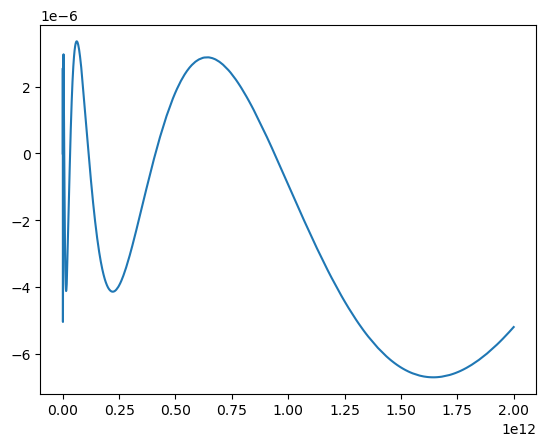

In [15]:
x = np.linspace(2000000000000,0,10001)
y = torch.tensor(np.arcsinh(x),device=device,dtype=torch.float64,requires_grad=True).reshape(10001,1)
U = model_U(y)
print(l)

Uy = grad(U.sum(), y, create_graph=True)[0]
#interior and smoothness losses
Fu = -l * U + ((1+l)*torch.sinh(y)+U)/torch.cosh(y)*Uy


fig = plt.figure()
plt.plot(x, Fu.detach().cpu().numpy())
plt.show()



In [16]:
torch.save(model_U.state_dict(), f"model_U_10000batch_20000its_weak.pth")

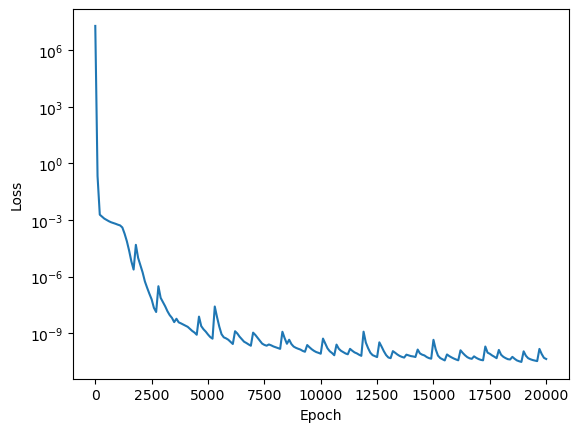

In [31]:
fig = plt.figure()
plt.xlabel('Epoch') 
plt.ylabel('Loss')
x=[i*100 for i in range(201)]
plt.semilogy(x,losses[:201])
plt.show()